In [1]:
import os
path = os.path.abspath(os.path.join('..','..'))
import sys
sys.path.append(path)
import pandas as pd
import numpy as np
from reservoirpy.materialbalancepy import mbe as mb
from reservoirpy.pvtpy import black_oil as bl
import matplotlib.pyplot as plt

In [2]:
data = np.array([
    [0.1000000, 0.0000000, 1.0000000, 0],
    [0.2000000, 0.0138408, 0.6869530, 0],
    [0.3000000, 0.0553633, 0.4471809, 0],
    [0.4000000, 0.1245675, 0.2709139, 0],
    [0.5000000, 0.2214533, 0.1483818, 0],
    [0.6000000, 0.3460208, 0.0698148, 0],
    [0.7000000, 0.4982699, 0.0254427, 0],
    [0.8000000, 0.6782007, 0.0054956, 0],
    [0.9000000, 0.8858131, 0.0002035, 0],
    [0.9500000, 1.0000000, 0.0000000, 0],
    [1.0000000, 1.0000000, 0.0000000, 0],
])
kr = mb.kr(data,columns=['sw','krw','kro','pc'])
kr

,krw,kro,pc
sw,,,
0.10,0.000000,1.000000,0.0
0.20,0.013841,0.686953,0.0
0.30,0.055363,0.447181,0.0
0.40,0.124567,0.270914,0.0
0.50,0.221453,0.148382,0.0
0.60,0.346021,0.069815,0.0
0.70,0.498270,0.025443,0.0
0.80,0.678201,0.005496,0.0
0.90,0.885813,0.000204,0.0


In [3]:
# Oil PVT
oil_pvt = bl.pvt({
    'pressure': [2925,2100,1800,1500],
    'bo':[1.429,1.480,1.468,1.440],
    'bt':[1.429,1.480,1.559,1.792],
    'rs':[1340,1340,1280,1150],
    'bg':[0.001,0.001283,0.001518,0.00183],
    'muo':[10,7,7.5,8],
    'mur':[0,34.1,38.3,42.4]
})

formation = 'fm1'
api = 25
pb = 2100
rsi = 1340
temp = 175

o = bl.oil(
    formation=formation,
    api=api,
    pb=pb,
    rsb=rsi,
    temp=temp,
    pvt=oil_pvt
)

In [4]:
# Water

w = bl.water(
    formation=formation,
    pb = pb,
    temp = temp)

w.pvt_from_correlations(start_pressure=1000,end_pressure=3000,n=5)
w.pvt

,rsw,cw,bw,muw,rhow
pressure,,,,,
1000.0,6.803417,0.000003,1.029221,0.375964,60.628376
1500.0,8.975257,0.000003,1.028531,0.375964,60.669053
2000.0,11.044822,0.000003,1.027709,0.375964,60.717562
2500.0,13.012112,0.000003,1.026144,0.375964,60.810184
3000.0,14.877126,0.000003,1.024409,0.375964,60.913157


In [5]:
swi=0.15
cf=4.9e-6
ooip=10e6

In [6]:
res1 = mb.reservoir(
    n=ooip,
    swi=swi,
    cf = cf,
    oil = o,
    water = w,
    pi=2925,    
    kr_wo = kr
)


In [7]:
r = np.linspace(2100,2900,10)[::-1]

r

array([2900.        , 2811.11111111, 2722.22222222, 2633.33333333,
       2544.44444444, 2455.55555556, 2366.66666667, 2277.77777778,
       2188.88888889, 2100.        ])

In [8]:
f_wp=res1.forecast_np(r,wp=True)
f = res1.forecast_np(r,wp=False)

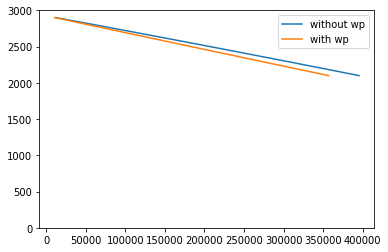

In [9]:
fig, ax = plt.subplots()
ax.plot(f['np'], f.index, label='without wp')
ax.plot(f_wp['np'], f_wp.index, label='with wp')
ax.set_ylim(0,3000)
ax.legend()

In [14]:
aq = mb.pot_aquifer(k=9987)

In [15]:
res1_aq = mb.reservoir(
    n=ooip,
    swi=swi,
    cf = cf,
    oil = o,
    water = w,
    pi=2925,    
    kr_wo = kr,
    aquifer = aq
)

In [16]:
f_aq= res1_aq.forecast_np(r,wp=True)
f_aq

,np,gp,wp,wor,bsw,sw
2900.000000,1.618515e+05,2.168810e+08,3.499957e+04,0.216245,0.177797,0.150000
2811.111111,7.086057e+05,9.495317e+08,1.956731e+05,0.276138,0.216386,0.162853
2722.222222,1.052342e+06,1.410139e+09,6.358044e+05,0.604180,0.376629,0.206340
2633.333333,1.224619e+06,1.640990e+09,1.313883e+06,1.072891,0.517582,0.232777
2544.444444,1.471513e+06,1.971827e+09,1.884071e+06,1.280364,0.561473,0.244681
2455.555556,1.593356e+06,2.135097e+09,2.628964e+06,1.649954,0.622635,0.263144
2366.666667,1.817393e+06,2.435306e+09,3.226484e+06,1.775337,0.639683,0.270924
2277.777778,1.886178e+06,2.527479e+09,4.043385e+06,2.143692,0.681903,0.287679
2188.888889,2.140484e+06,2.868249e+09,4.592778e+06,2.145672,0.682103,0.291015
2100.000000,2.060840e+06,2.761525e+09,5.620220e+06,2.727150,0.731699,0.310668


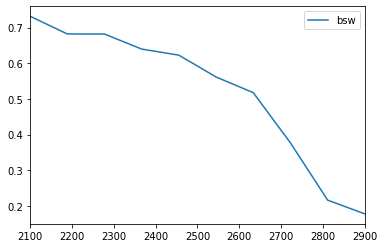

In [17]:
f_aq.plot(y='bsw')